In [1]:
###This notebook contains the analysis of RandSampleDataset

In [2]:
##Importing the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from pandas.api.types import is_bool_dtype, is_object_dtype, is_numeric_dtype,is_datetime64_any_dtype
from dateutil.parser import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error,r2_score
import pickle

In [3]:
###Loading the csv file  RandSampleDataset
random_df = pd.read_csv("RandSampleDataset.csv")


In [4]:
##printing the first five rows of the dataset
random_df.head()

,ID,Facility_Name,ZIP5,Initial_Balance,Home_Phone,Has2Ins,DOB_Age,Financial_Class,Assign_Age,Employed,Payment
0,1,Hospital ABC,91006,36122,1,0,95,COMM,329,NaN,0.0
1,2,Doctor Who,91001,560,1,0,53,COMM,389,NaN,344.0
2,3,Bloodwork Inc,90815,51,1,1,28,MEDI,381,Wallmart,0.0
3,4,Anes Group,90814,3682,1,0,59,COMM,222,Wallmart,500.0
4,5,Clinic Clinic,90813,128,1,1,46,MEDI,182,None,2.0


In [5]:
##let's look at the dimensions of the dataframe rand_df
random_df.shape

(5000, 11)

In [6]:
##Loading the xslx file Rand_Sample_Zip_Income file
rand_Income_df = pd.read_excel("Rand_Sample_Zip_Income.xls")

In [7]:
##Printing the first five rows of the dataset
rand_Income_df.head(5)

,Zip,Median $,Pop
0,91006,94085,31715
1,91001,83859,36126
2,90815,71281,34554
3,90814,64440,19131
4,90813,28806,56379


In [8]:
##let's look at the dimensions of the dataframe rand_Income_df
rand_Income_df.shape

(100, 3)

In [9]:
### Merging the two dataframes based on ZIP Columns

In [10]:
rand_df = random_df.merge(rand_Income_df, how='left', left_on='ZIP5', right_on='Zip')

In [11]:
##Dropping the Zip column as ZIP5 column is same Zip
rand_df = rand_df.drop("Zip",axis = 1)

In [12]:
##Renaming the column Median $
rand_df = rand_df.rename({'Median $':'Median_Income_Dollars'},axis = 1)

In [13]:
rand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     5000 non-null   int64  
 1   Facility_Name          5000 non-null   object 
 2   ZIP5                   5000 non-null   int64  
 3   Initial_Balance        5000 non-null   int64  
 4   Home_Phone             5000 non-null   int64  
 5   Has2Ins                5000 non-null   int64  
 6   DOB_Age                5000 non-null   int64  
 7   Financial_Class        5000 non-null   object 
 8   Assign_Age             5000 non-null   int64  
 9   Employed               3645 non-null   object 
 10  Payment                5000 non-null   float64
 11  Median_Income_Dollars  4782 non-null   float64
 12  Pop                    4782 non-null   float64
dtypes: float64(3), int64(7), object(3)
memory usage: 546.9+ KB


### Profiling the Dataset Statistics

In [14]:
## This class provides completed profile of the dataset like number of null values,non-null values,mean,median,mode,unique values
##shortest word, longest words in the columns of the dataset we are passing.

class DataProfiling(object):
    '''
    :

    Attributes
    ----------
    data: pd.DataFrame -- The data to be investigated
    path: str -- The path for saving the results
    numerical_columns: list -- The name of the numeric variables (columns) in the data
    object_columns: list -- The name of the non-numeric variables (columns) in the data
    datetime_columns: list -- The name of the date-time type variables (columns) in the data
    string_columns: list -- The name of the string type variables (columns) in the data
    numeric_data: pd.DataFrame -- The numeric variables (columns) of the data
    string_data: pd.DataFrame -- The string type variables (columns) of the data
    datetime_data: pd.DataFrame -- The date-time type variables (columns) of the data
    non_numeric_data: pd.DataFrame -- The non-numeric variables (columns) of the data
    numeric_profile_df: pd.DataFrame -- The data profile for numeric variables (columns)
    non_numeric_profile_df: pd.DataFrame -- The data profile for non-numeric variables (columns)
    total_profile_df: pd.DataFrame -- The data profile for all variables (columns)


    Methods
    --------
    datetime_identification: This functions looks at the non-numeric columns of the data and search if they have any
        date/time format. Then returns the name of those columns.
    numeric_profile: This function takes the numeric variables of the data and for each variable generates a basic data
        description such as
            - The type of the variable as numeric, the size of the data,
            - The max, min, mean, median, standard deviation  and the range of the variable,
            - Number of nulls, non-nulls and percentage of null values,
            - The unique values , number of unique values and their frequency counts
            - The longest and shortest length of the string version of values and their values, and the shortest length
             of the non-null value for each variable.
            - The top frequent value and the count is set to NA as they are set for non-numeric variables

    non_numeric_profile: This function takes the non-numeric variables of the data and for each variable generates a
        basic data description such as
            - The type of the variable as non-numeric, the size of the data,
            - The max and min values as teh first  and the last values when the variable is sorted
            - The median, standard deviation  and the range of the variable are set to NA
            - Number of nulls, non-nulls and percentage of null values,
            - The unique values , number of unique values and their frequency counts
            - The longest and shortest length of values and their values, and the shortest length of the non-null
              value for each variable.
            - The top most frequent value and the count
    '''

    def __init__(self, data:pd.DataFrame, path=''):
        """
        :Description: This functions looks at the non-numeric columns od the data and search if they have any
            date/time format. Then returns the name of those columns.

        :param data: The data to be investigated.
        :type data: pandas dataframe
        :param path: the path to save the plot in.
        :type path: str

        """

        self.data = data.copy(deep=True)
        self.path = path
        # self.features =list(data.columns)

        # Identifying empty columns
        self.empty_columns = [cols for cols in data.columns
                              if len(data[cols].dropna()) == 0
                              and sum(data[cols].notnull()) == 0
                              ]


        # Identifying the columns with numerical type
        self.numerical_columns = [cols for cols in data.columns
                                   if is_numeric_dtype(data[cols])
                                   and not is_bool_dtype(data[cols])
                                   
                                   and len(data[cols].dropna()) > 0
                                   and sum(data[cols].notnull()) > 0
                                   ]
        #Identifying the columns with object type
        self.object_columns = [cols for cols in data.columns
                                   if is_object_dtype(data[cols])
                                   or is_bool_dtype(data[cols])
                                   
                                   and len(data[cols].dropna()) > 0
                                   and sum(data[cols].notnull()) > 0
                                   ]
        
        self.date_columns = [cols for cols in data.columns
                                   if is_datetime64_any_dtype(data[cols])
                                   and not is_bool_dtype(data[cols])
                                   and not is_numeric_dtype(data[cols])
                             
                                   and len(data[cols].dropna()) > 0
                                   and sum(data[cols].notnull()) > 0
                            ]

        
        

        self.numeric_data = data[self.numerical_columns]
       
        self.non_numeric_data = data[self.object_columns]
        self.date_data = data[self.date_columns]

        self.numeric_profile_df = self.numeric_profile()
        self.non_numeric_profile_df = self.non_numeric_profile()
        self.empty_profile_df = self.empty_profile()
        self.date_profile_df = self.date_profile()
        
        self.total_profile_df = pd.concat([self.date_profile_df,self.numeric_profile_df, self.non_numeric_profile_df]\
                                          , axis=1)


    
    def date_profile(self)->pd.DataFrame:
        prof = pd.DataFrame()
        for col in self.date_columns:
            df = self.data.loc[:,col]
            prof.loc['Type', col] = "date"
            prof.loc['Size', col] = len(df)
            prof.loc['Number of Unique Values', col] = df.nunique()
            prof.loc['Allowed Values', col] = df.unique()
            hist = pd.DataFrame(pd.Series(df.value_counts())
                                    .reset_index().values
                                    ,columns=['name','num'])
            prof.loc['Freq_Count_Distr', col] = hist.loc[0, 'num']
            prof.loc['Shortest Non-Blank Length', col] = df.astype('str').str.len().min()
            prof.loc['Shortest Non-Blank Value', col] = self.data.loc[df.astype('str').str.len().idxmin(),col]
            prof.loc['Longest Non-Blank Length', col] = df.astype('str').str.len().max()
            prof.loc['Longest Non-Blank Value', col] = self.data.loc[df.astype('str').str.len().idxmax(),col]
            prof.loc['MinValue', col] = df.sort_values(ascending=True).reset_index(drop=True)[0]

            try:
                prof.loc['MaxValue',col] = df.sort_values(ascending=False).reset_index(drop=True)[0]
            except:
                df = self.data.loc[:, col].astype('str')
                prof.loc['MaxValue', col] = df.sort_values(ascending=False).reset_index(drop=True)[0]
                 

                
            prof.loc['MeanValue', col] = 'NA'
            prof.loc['MedianValue', col] = 'NA'
            prof.loc['ModeValue', col] = 'NA'
            prof.loc['StdValue', col] = 'NA'
            prof.loc['Range', col] = 'NA'
            prof.loc['Num_NonNull_Count', col] = df.count()
            prof.loc['Num_NullCount', col] = sum(df.isna() | df.isnull())
            prof.loc['PercentNull_Count', col] = \
                round(sum(df.isna() | df.isnull()) * 100 / len(df), 2)


                      
        return prof
            
    def numeric_profile(self) -> pd.DataFrame:
        '''
        :Description: This function takes the numeric variables of the data and for each variable generates a basic data
        description such as
            - The type of the variable as numeric, the size of the data,
            - The max, min, mean, median, standard deviation  and the range of the variable,
            - Number of nulls, non-nulls and percentage of null values,
            - The unique values , number of unique values and their frequency counts
            - The longest and shortest length of the string version of values and their values, and the shortest length
             of the non-null value for each variable.
            - The top frequent value and the count is set to NA as they are set for non-numeric variables

        :return: pd.DataFrame --  A descriptive information about numerical variables of the data
        '''
    
        #Making a profile data frame
        prof = pd.DataFrame()

        for col in self.numerical_columns:
            df = self.data[col]
            prof.loc['Type', col] = 'Numeric'
            prof.loc['Size', col] = len(df)
            prof.loc['Number of Unique Values', col] = df.nunique()
            prof.loc['Allowed Values', col] = df.unique()
            hist = pd.DataFrame(pd.Series(df.value_counts())
                                    .reset_index().values
                                    ,columns=['name','num'])
            prof.loc['Freq_Count_Distr', col] = hist.loc[0, 'num']
            prof.loc['Shortest Non-Blank Length', col] =  'NA'
            prof.loc['Shortest Non-Blank Value', col] = 'NA'
            prof.loc['Longest Non-Blank Length', col] = 'NA'
            prof.loc['Longest Non-Blank Value', col] = 'NA'
            prof.loc['MinValue', col] = df.min()
            prof.loc['MaxValue',col] = df.max()
            prof.loc['Range', col] = df.max() - df.min()
            prof.loc['MeanValue', col] = round(df.mean(),2)
            prof.loc['MedianValue', col] = round(df.median(),2)
            prof.loc['ModeValue', col] = df.mode()[0]
            prof.loc['StdValue', col] = round(np.std(df),2)
            prof.loc['Num_NonNull_Count', col] = df.count()
            prof.loc['Num_NullCount', col] = sum(df.isna() | df.isnull())
            prof.loc['PercentNull_Count', col] = \
                round(sum(df.isna() | df.isnull()) * 100 / len(df), 2)
           
        return prof


    def non_numeric_profile(self) -> pd.DataFrame:
        '''
        :Description: This function takes the non-numeric variables of the data and for each variable generates a
        basic data description such as
            - The type of the variable as non-numeric, the size of the data,
            - The max and min values as teh first  and the last values when the variable is sorted
            - The median, standard deviation  and the range of the variable are set to NA
            - Number of nulls, non-nulls and percentage of null values,
            - The unique values , number of unique values and their frequency counts
            - The longest and shortest length of values and their values, and the shortest length of the non-null
              value for each variable.
            - The top most frequent value and the count

        :return: pd.DataFrame -- A descriptive information about non-numerical variables of the data
        '''

        #Making a profile data frame
        prof = pd.DataFrame()

        for col in self.object_columns:
            df = self.data.loc[:,col]
            prof.loc['Type', col] = "non-numeric"
            prof.loc['Size', col] = len(df)
            prof.loc['Number of Unique Values', col] = df.nunique()
            prof.loc['Allowed Values', col] = df.unique()
            hist = pd.DataFrame(pd.Series(df.value_counts())
                                    .reset_index().values
                                    ,columns=['name','num'])
            prof.loc['Freq_Count_Distr', col] = hist.loc[0, 'num']
            prof.loc['Shortest Non-Blank Length', col] = df.astype('str').str.len().min()
            prof.loc['Shortest Non-Blank Value', col] = self.data.loc[df.astype('str').str.len().idxmin(),col]
            prof.loc['Longest Non-Blank Length', col] = df.astype('str').str.len().max()
            prof.loc['Longest Non-Blank Value', col] = self.data.loc[df.astype('str').str.len().idxmax(),col]
            
            try:
                prof.loc['MinValue', col] = df.sort_values(ascending=True).reset_index(drop=True)[0]
            except:
                df = self.data.loc[:, col].astype('str')
                prof.loc['MinValue', col] = df.sort_values(ascending=False).reset_index(drop=True)[0]

            try:
                prof.loc['MaxValue',col] = df.sort_values(ascending=False).reset_index(drop=True)[0]
            except:
                df = self.data.loc[:, col].astype('str')
                prof.loc['MaxValue', col] = df.sort_values(ascending=False).reset_index(drop=True)[0]
                 

                
            prof.loc['MeanValue', col] = 'NA'
            prof.loc['MedianValue', col] = 'NA'
            prof.loc['ModeValue', col] = 'NA'
            prof.loc['StdValue', col] = 'NA'
            prof.loc['Range', col] = 'NA'
            prof.loc['Num_NonNull_Count', col] = df.count()
            prof.loc['Num_NullCount', col] = sum(df.isna() | df.isnull())
            prof.loc['PercentNull_Count', col] = \
                round(sum(df.isna() | df.isnull()) * 100 / len(df), 2)


                   
            
        return prof
    
                    

    def empty_profile(self) -> pd.DataFrame:
        '''
        :Description: This function takes the empty variables of the data

        :return: pd.DataFrame --  A descriptive information about numerical variables of the data
        '''

        #Making a profile data frame
        prof = pd.DataFrame()

        for col in self.empty_columns:
            df = self.data.loc[:,col]
            prof.loc['Type', col] = 'EMPTY'
            prof.loc['Size', col] = len(df)
            prof.loc['Number of Unique Values', col] = 'NA'
            prof.loc['Allowed Values', col] = 'NA'
            prof.loc['Freq_Count_Distr', col] = 'NA'
            prof.loc['Shortest Non-Blank Length', col] ='NA'
            prof.loc['Shortest Non-Blank Value', col] = 'NA'
            prof.loc['Longest Non-Blank Length', col] = 'NA'
            prof.loc['Longest Non-Blank Value', col] = 'NA'
            prof.loc['MinValue', col] = 'NA'
            prof.loc['MaxValue',col] = 'NA'
            prof.loc['MeanValue', col] = 'NA'
            prof.loc['MedianValue', col] = 'NA'
            prof.loc['ModeValue', col] = 'NA'
            prof.loc['StdValue', col] = 'NA'
            prof.loc['Range', col] = 'NA'
            prof.loc['Num_NonNull_Count', col] = 0
            prof.loc['Num_NullCount', col] = len(df)
            prof.loc['PercentNull_Count', col] = 100
            
            
           

        return prof



In [15]:
##Profiling RandSampleDataset
profile_df = DataProfiling(rand_df)

In [16]:
##Results of profiling Rand Sample dataset
profile_df.total_profile_df

,ID,ZIP5,Initial_Balance,Home_Phone,Has2Ins,DOB_Age,Assign_Age,Payment,Median_Income_Dollars,Pop,Facility_Name,Financial_Class,Employed
Type,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,non-numeric,non-numeric,non-numeric
Size,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
Number of Unique Values,5000,101,2351,2,2,82,271,652,100,99,5,3,16
Allowed Values,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[91006, 91001, 90815, 90814, 90813, 90810, 908...","[36122, 560, 51, 3682, 128, 2593, 950, 88, 553...","[1, 0]","[0, 1]","[95, 53, 28, 59, 46, 37, 98, 56, 65, 39, 47, 6...","[329, 389, 381, 222, 182, 304, 332, 400, 291, ...","[0.0, 344.0, 500.0, 2.0, 444.0, 477.0, 137.0, ...","[94085.0, 83859.0, 71281.0, 64440.0, 28806.0, ...","[31715.0, 36126.0, 34554.0, 19131.0, 56379.0, ...","[Hospital ABC, Doctor Who, Bloodwork Inc, Anes...","[COMM, MEDI, None]","[nan, Wallmart, None, Other, NBA, Microsoft, D..."
Freq_Count_Distr,1,218,16,4770,4454,80,30,3500,66,88,1479,3372,1559
Shortest Non-Blank Length,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,10,4,3
Shortest Non-Blank Value,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Doctor Who,COMM,NaN
Longest Non-Blank Length,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,13,4,9
Longest Non-Blank Value,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Bloodwork Inc,COMM,Microsoft
MinValue,1,90000,1,0,0,18,180,0,28806,456,Anes Group,COMM,Apple


### Data Cleaning of Rand Sample dataset 

In [17]:
## Function to impute null value with new category in Employed
def impute_nan_create_category(DataFrame,ColName):
     DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),"Unknown",DataFrame[ColName])
## Call function to create new category for variables
for Columns in rand_df:
    impute_nan_create_category(rand_df,'Employed')

In [18]:
##Checking whether in Employed column nan is replaced by "Unknown"
rand_df[rand_df['Employed']=='Unknown']


,ID,Facility_Name,ZIP5,Initial_Balance,Home_Phone,Has2Ins,DOB_Age,Financial_Class,Assign_Age,Employed,Payment,Median_Income_Dollars,Pop
0,1,Hospital ABC,91006,36122,1,0,95,COMM,329,Unknown,0.00,94085.0,31715.0
1,2,Doctor Who,91001,560,1,0,53,COMM,389,Unknown,344.00,83859.0,36126.0
5,6,Hospital ABC,90810,2593,1,0,37,COMM,304,Unknown,444.00,52385.0,36727.0
10,11,Hospital ABC,90804,31934,1,0,47,COMM,379,Unknown,0.00,41340.0,39349.0
11,12,Doctor Who,90803,347,1,0,60,COMM,332,Unknown,137.00,72287.0,32031.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,4989,Anes Group,90604,2730,1,0,52,COMM,287,Unknown,299.00,69646.0,39407.0
4992,4993,Bloodwork Inc,90505,61,1,0,45,COMM,215,Unknown,53.67,76461.0,36678.0
4994,4995,Doctor Who,90503,935,1,0,29,COMM,418,Unknown,0.00,79998.0,44383.0
4995,4996,Doctor Who,90502,964,1,0,47,MEDI,393,Unknown,0.00,65676.0,18010.0


In [19]:
rand_df = rand_df.dropna()
rand_df.reset_index(drop=True,inplace=True)

In [20]:
rand_df

,ID,Facility_Name,ZIP5,Initial_Balance,Home_Phone,Has2Ins,DOB_Age,Financial_Class,Assign_Age,Employed,Payment,Median_Income_Dollars,Pop
0,1,Hospital ABC,91006,36122,1,0,95,COMM,329,Unknown,0.0,94085.0,31715.0
1,2,Doctor Who,91001,560,1,0,53,COMM,389,Unknown,344.0,83859.0,36126.0
2,3,Bloodwork Inc,90815,51,1,1,28,MEDI,381,Wallmart,0.0,71281.0,34554.0
3,4,Anes Group,90814,3682,1,0,59,COMM,222,Wallmart,500.0,64440.0,19131.0
4,5,Clinic Clinic,90813,128,1,1,46,MEDI,182,None,2.0,28806.0,56379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,4996,Doctor Who,90502,964,1,0,47,MEDI,393,Unknown,0.0,65676.0,18010.0
4778,4997,Doctor Who,90501,45,1,0,99,COMM,336,NBA,0.0,60024.0,43180.0
4779,4998,Doctor Who,90405,774,1,0,53,COMM,432,Dell,0.0,74562.0,27186.0
4780,4999,Doctor Who,90404,365,1,0,84,COMM,185,Unknown,0.0,56318.0,21360.0


### Univariate Analysis

In [21]:
##Analyzing Categorical dataset

Text(0.5, 1.0, 'Frequencies by type of Facility_Name')

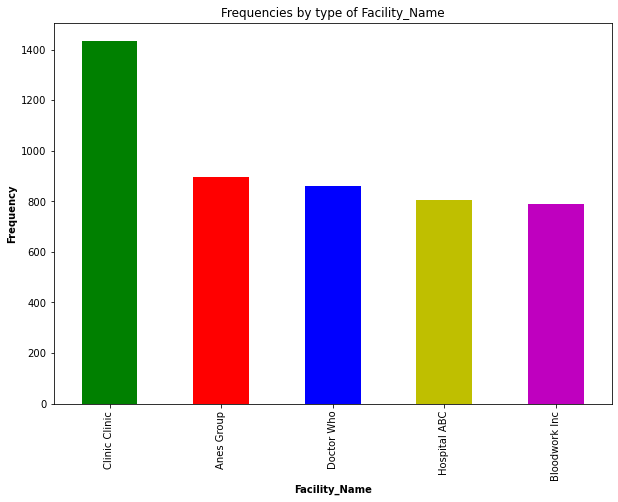

In [22]:
##Exploratory Data Analysis on Rand Sample dataset
fig = plt.figure(figsize =(10, 7))
rand_df['Facility_Name'].value_counts().plot.bar(color = ['g','r','b','y','m']).get_figure()
plt.xlabel('Facility_Name', fontweight ='bold', fontsize = 10)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 10)
plt.title("Frequencies by type of Facility_Name") 

In [23]:
##Calculating the percentage of the major Facilty name from rand sample dataset
rand_df.Facility_Name.value_counts(normalize=True)

Clinic Clinic    0.299875
Anes Group       0.187160
Doctor Who       0.179841
Hospital ABC     0.168130
Bloodwork Inc    0.164994
Name: Facility_Name, dtype: float64

##### From the above chart we can visually see about 30% of the Payment should be coming from the facility Clinic Clinic

Text(0.5, 1.0, 'Frequencies by type of Financial Class')

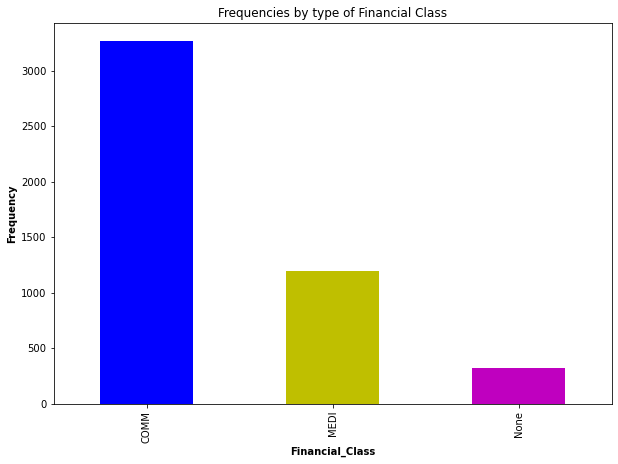

In [24]:
fig = plt.figure(figsize =(10, 7))
rand_df['Financial_Class'].value_counts().plot.bar(color = ['b','y','m']).get_figure()
plt.xlabel('Financial_Class', fontweight ='bold', fontsize = 10)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 10)
plt.title("Frequencies by type of Financial Class") 

In [25]:
##Calculating the percentage of the major Financial_Class from rand sample dataset
rand_df.Financial_Class.value_counts(normalize=True)

COMM    0.682769
MEDI    0.249895
None    0.067336
Name: Financial_Class, dtype: float64

# From the Financial Bar Chart we can infer 68% of the Facilities falls under Financial class of COMM

Text(0.5, 1.0, 'Frequencies by type of Employed')

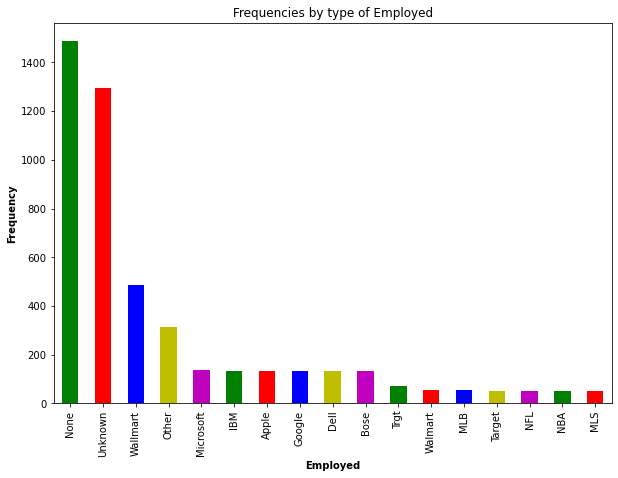

In [26]:
fig = plt.figure(figsize =(10, 7))
rand_df['Employed'].value_counts().plot.bar(color = ['g','r','b','y','m']).get_figure()
plt.xlabel('Employed', fontweight ='bold', fontsize = 10)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 10)
plt.title("Frequencies by type of Employed") 

In [27]:
##Calculating the percentage of the major Employed from rand sample dataset
rand_df.Employed.value_counts(normalize=True)

None         0.311167
Unknown      0.271225
Wallmart     0.101631
Other        0.065872
Microsoft    0.028440
IBM          0.028231
Apple        0.028022
Google       0.028022
Dell         0.028022
Bose         0.027604
Trgt         0.015056
Walmart      0.011501
MLB          0.011501
Target       0.011083
NFL          0.011083
NBA          0.010874
MLS          0.010665
Name: Employed, dtype: float64

##### From above Employed Feature we can understand that 58% of the values have none and unknown values

Text(0.5, 1.0, 'Distribution of Initial_Balance')

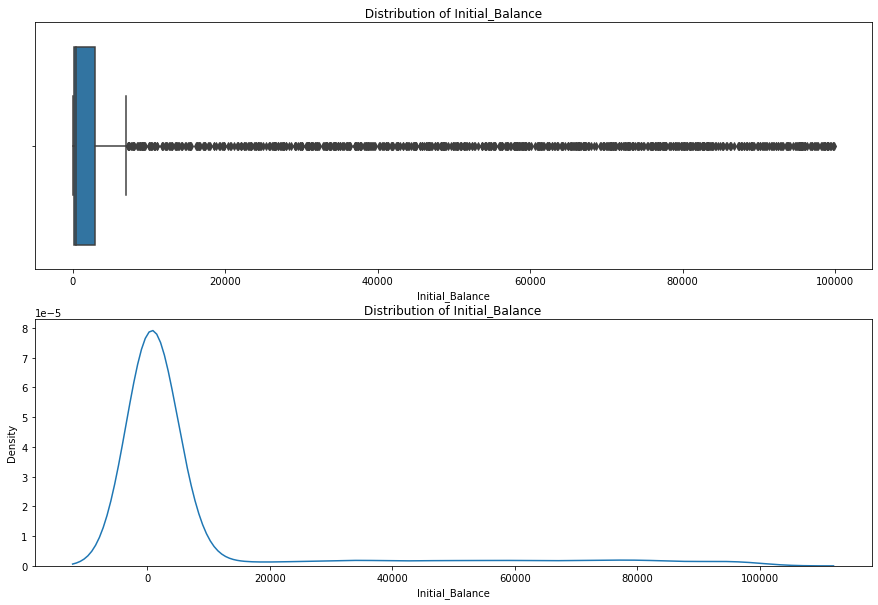

In [28]:
plt.figure(figsize = (15, 10))

plt.subplot(211)
sns.boxplot(rand_df['Initial_Balance'])
plt.title(" Distribution of Initial_Balance ") 

plt.subplot(212)
sns.kdeplot(rand_df['Initial_Balance'])
plt.title("Distribution of Initial_Balance") 

##From the Box and Distribution plots it's right taled distribution

<AxesSubplot:xlabel='Payment', ylabel='Density'>

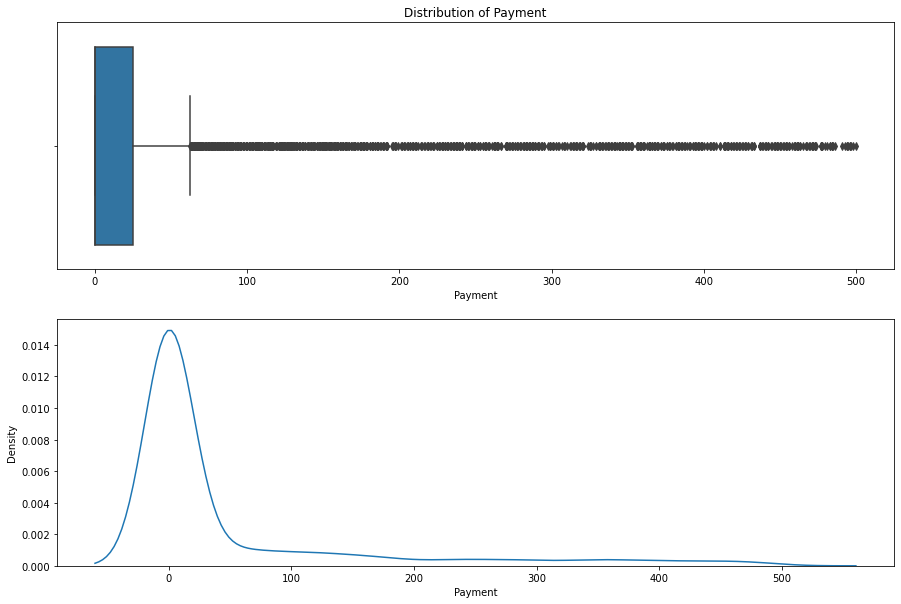

In [29]:
plt.figure(figsize = (15, 10))

plt.subplot(211)
sns.boxplot(rand_df['Payment'])
plt.title("Distribution of Payment") 

plt.subplot(212)
sns.kdeplot(rand_df['Payment'])


##From the Box and Distribution plots it's payment is right taled distribution

<AxesSubplot:xlabel='Median_Income_Dollars', ylabel='Density'>

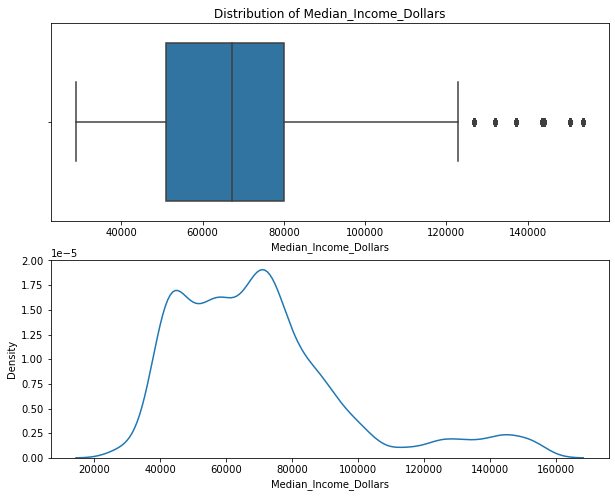

In [30]:
plt.figure(figsize = (10, 8))

plt.subplot(211)
sns.boxplot(rand_df['Median_Income_Dollars'])
plt.title("Distribution of Median_Income_Dollars") 

plt.subplot(212)
sns.kdeplot(rand_df['Median_Income_Dollars'])


In [31]:
###Median_Income_Dollars box and distribution has normal distribution with mean of 70190.59

<AxesSubplot:xlabel='Pop', ylabel='Density'>

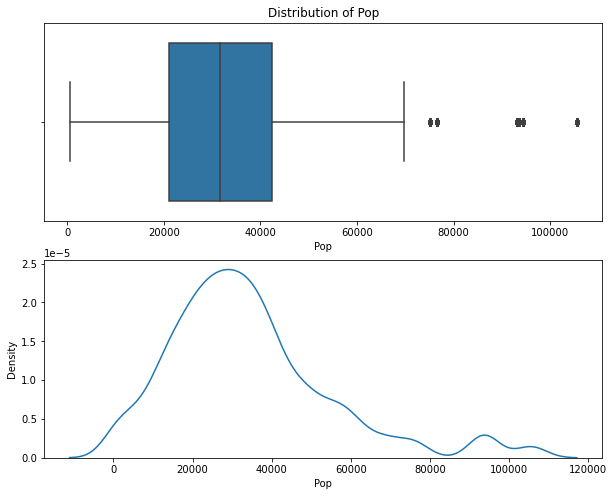

In [32]:
plt.figure(figsize = (10, 8))

plt.subplot(211)
sns.boxplot(rand_df['Pop'])
plt.title("Distribution of Pop") 

plt.subplot(212)
sns.kdeplot(rand_df['Pop'])


In [33]:
rand_df['Pop'].mean()

34399.133626097864

In [34]:
###Pop box and distribution has normal distribution with mean of .59

Text(0.5, 1.0, 'DOB_Age Frequency Distribution')

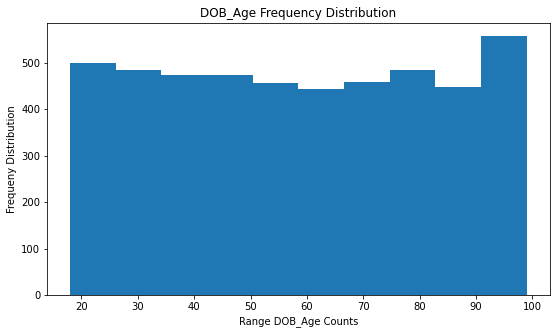

In [35]:
plt.figure(figsize = (9, 5))
rand_df["DOB_Age"].plot.hist()
plt.xlabel ('Range DOB_Age Counts')
plt.ylabel ('Frequeny Distribution')
plt.title ('DOB_Age Frequency Distribution')

### DOB_Age Bins the data points frequency is with all ages from 20 t0 100

Text(0.5, 1.0, 'Assign_Age Frequency Distribution')

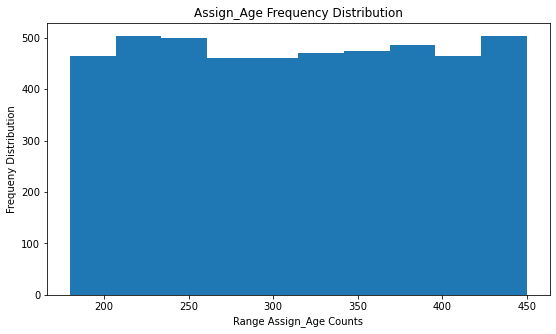

In [36]:
plt.figure(figsize = (9, 5))
rand_df["Assign_Age"].plot.hist()
plt.xlabel ('Range Assign_Age Counts')
plt.ylabel ('Frequeny Distribution')
plt.title ('Assign_Age Frequency Distribution')

In [37]:
### Assign_Age Bins the data points frequency is with all ages from 150 t0 450

# Bivariate Analysis

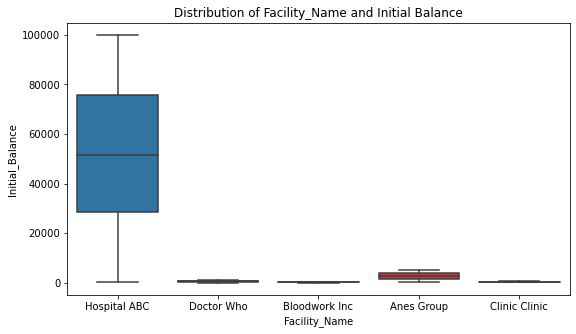

In [38]:
# Create a box plot with grouping by a categorical variable
plt.figure(figsize = (9, 5))
sns.boxplot(x="Facility_Name", y="Initial_Balance", data=rand_df)
plt.title("Distribution of Facility_Name and Initial Balance") 
plt.show()

From the above box plot Hospital ABC Facility is having more distribution of initial Balance compared other Facility Names

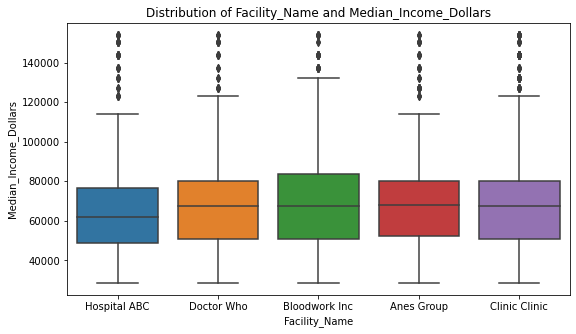

In [39]:
plt.figure(figsize = (9, 5))
sns.boxplot(x="Facility_Name", y="Median_Income_Dollars", data=rand_df)
plt.title("Distribution of Facility_Name and Median_Income_Dollars")
plt.show()

From the above box plot distribution of Median_Income_Dollars for Facility Names are ranging same

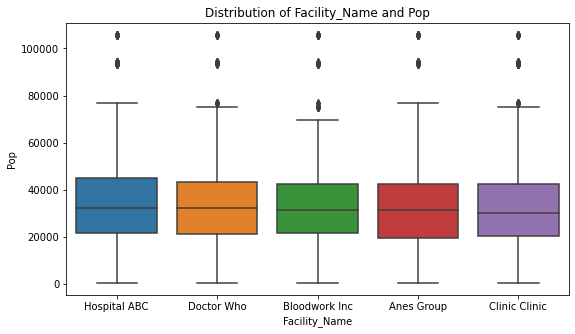

In [40]:
plt.figure(figsize = (9, 5))
sns.boxplot(x="Facility_Name", y="Pop", data=rand_df)
plt.title("Distribution of Facility_Name and Pop")
plt.show()

From the above box plot distribution of Pop for Facility Names are ranging same

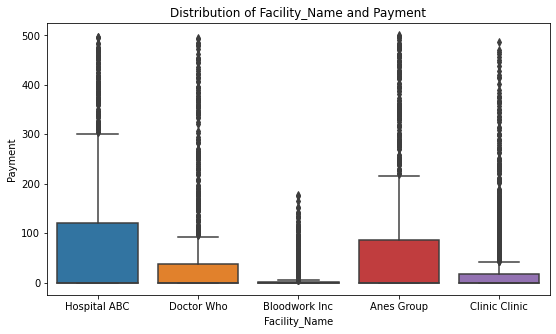

In [41]:
plt.figure(figsize = (9, 5))
sns.boxplot(x="Facility_Name", y="Payment", data=rand_df)
plt.title("Distribution of Facility_Name and Payment")
plt.show()

From the above box plot distribution of Facility name and Payment for Facility Name Hospital ABC and Anes Group have more distribution than other Facilities

Text(0.5, 1.0, 'Scatter plot of Initial Balance and Payment')

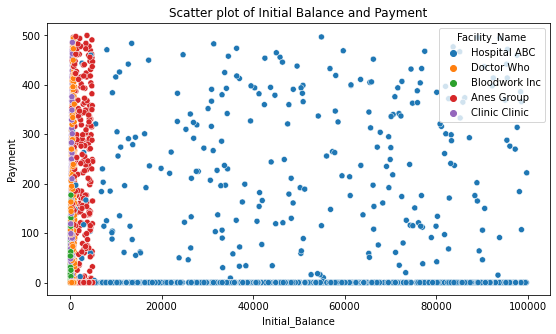

In [42]:
plt.figure(figsize = (9, 5))
sns.scatterplot(data=rand_df, x="Initial_Balance", y="Payment", hue="Facility_Name")
plt.title("Scatter plot of Initial Balance and Payment")


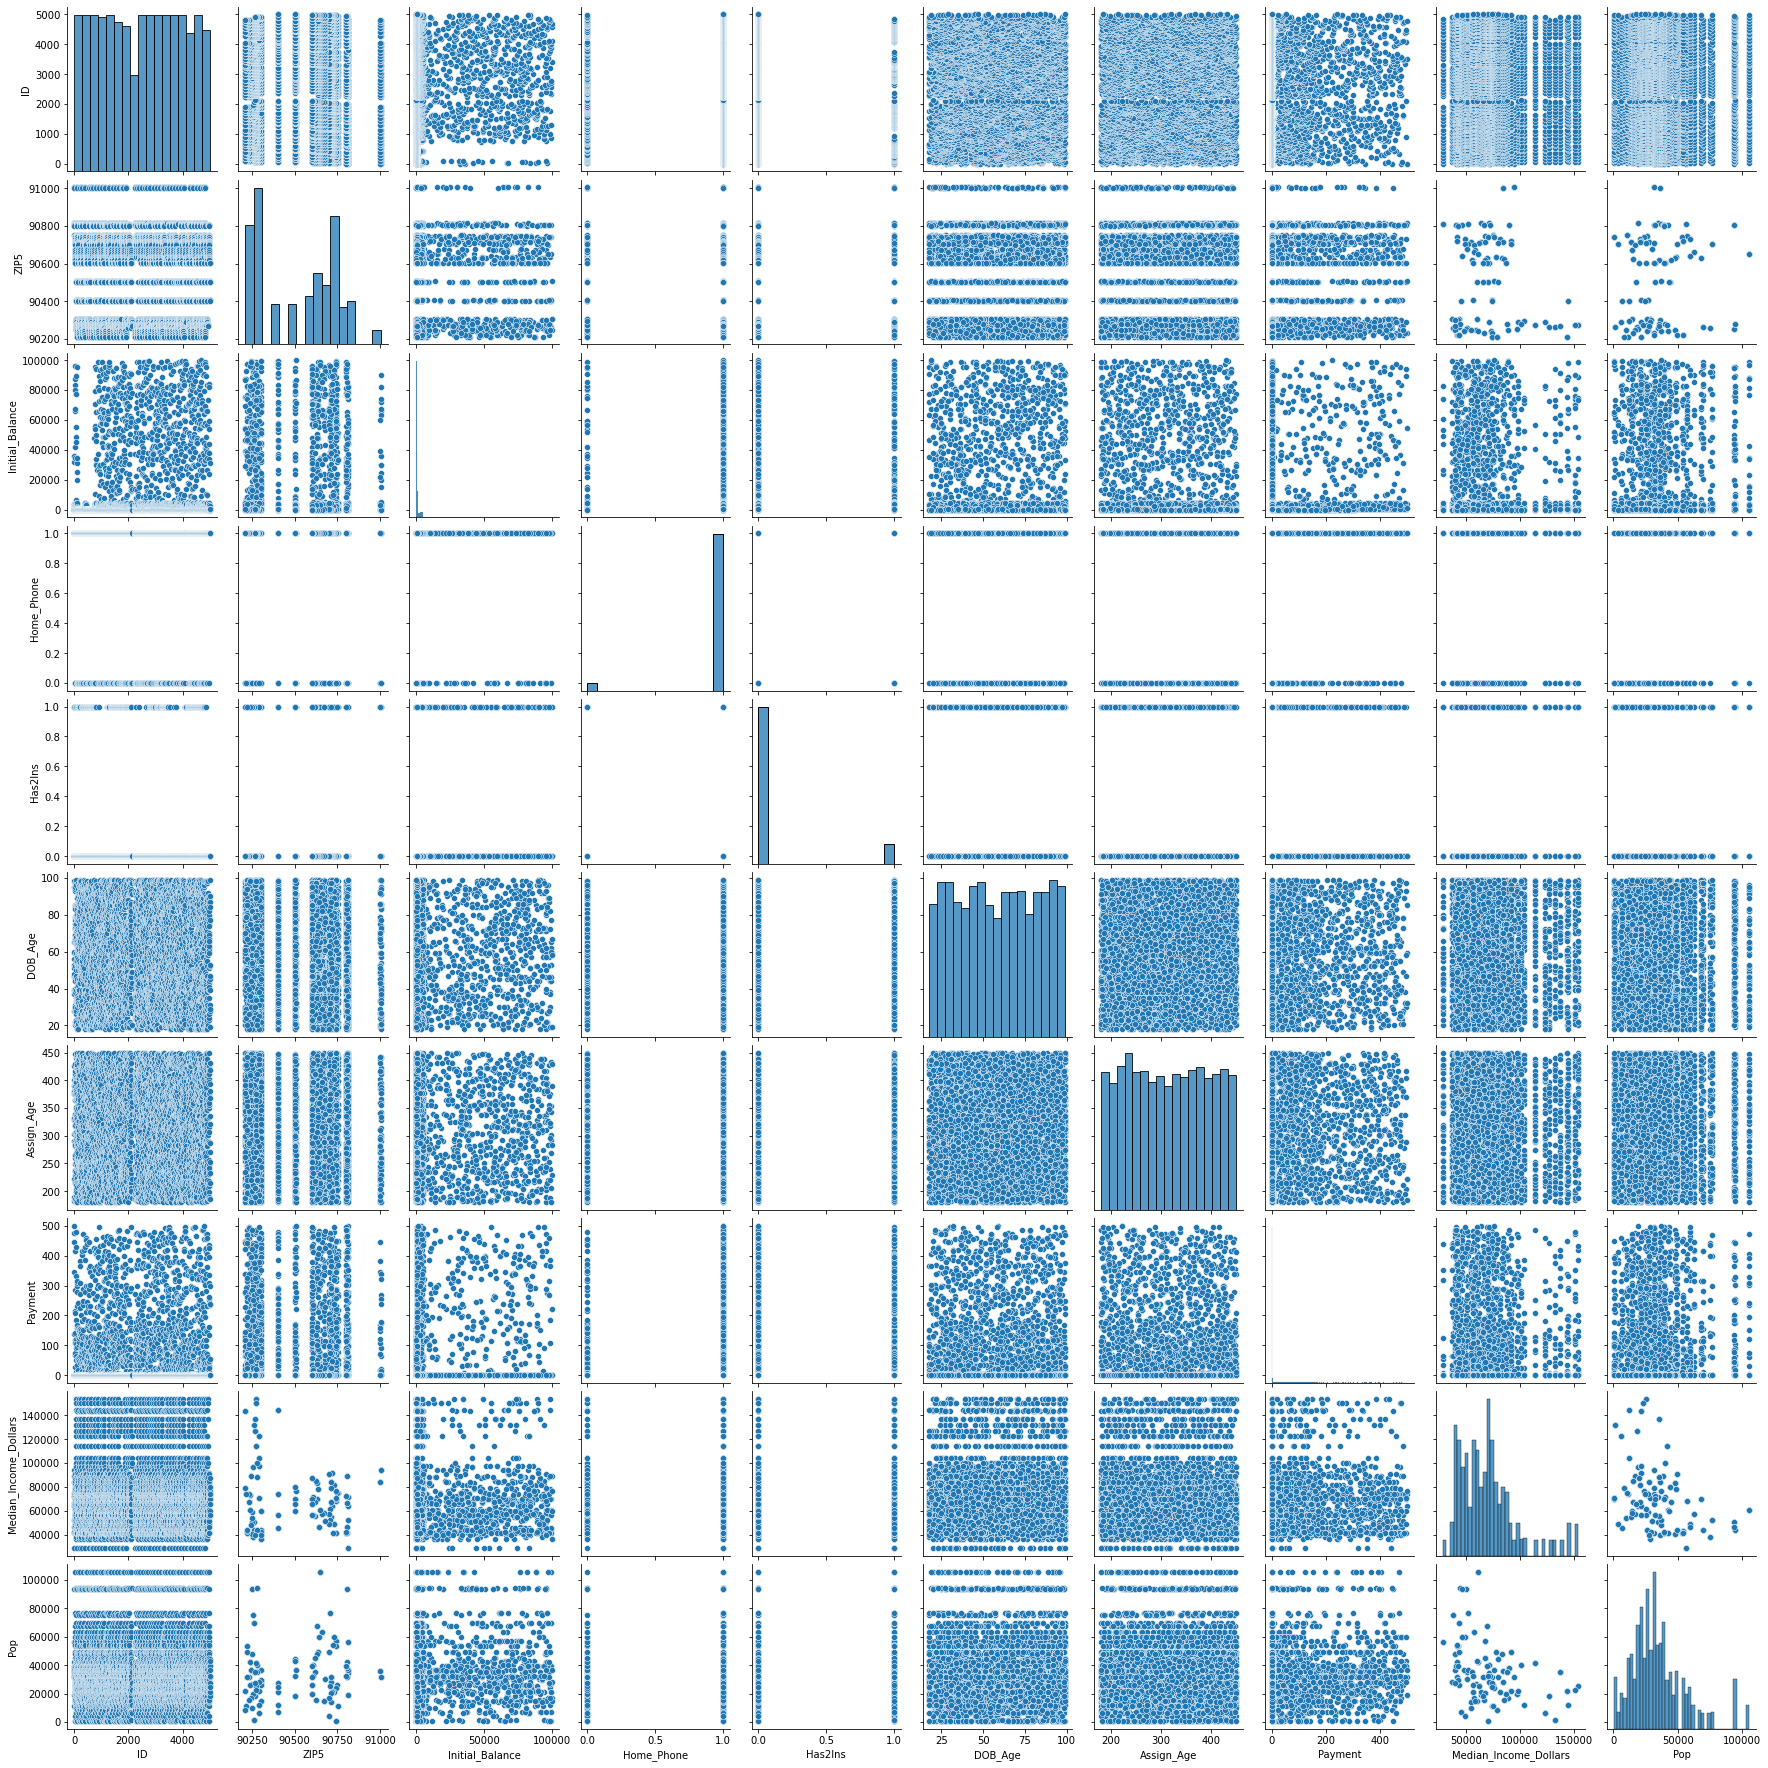

In [43]:
sns.pairplot(rand_df)

### Feature Engineering



In [44]:
##Finding the percentage of payment from the Initial Balance
rand_df['Percent_paid'] = rand_df['Payment']/rand_df['Initial_Balance'] *100

In [45]:
###Finding the due payment from Initial Balance
rand_df['Due_payment'] = rand_df['Initial_Balance']-rand_df['Payment']

In [46]:
###Categorising the age into Youth, Adults and Seniors
bins= [18,30,64,100]
labels = ['Youth','Adults','Senior']
rand_df['AgeGroup'] = pd.cut(rand_df['DOB_Age'], bins=bins, labels=labels, right=False)

In [47]:
rand_df

,ID,Facility_Name,ZIP5,Initial_Balance,Home_Phone,Has2Ins,DOB_Age,Financial_Class,Assign_Age,Employed,Payment,Median_Income_Dollars,Pop,Percent_paid,Due_payment,AgeGroup
0,1,Hospital ABC,91006,36122,1,0,95,COMM,329,Unknown,0.0,94085.0,31715.0,0.000000,36122.0,Senior
1,2,Doctor Who,91001,560,1,0,53,COMM,389,Unknown,344.0,83859.0,36126.0,61.428571,216.0,Adults
2,3,Bloodwork Inc,90815,51,1,1,28,MEDI,381,Wallmart,0.0,71281.0,34554.0,0.000000,51.0,Youth
3,4,Anes Group,90814,3682,1,0,59,COMM,222,Wallmart,500.0,64440.0,19131.0,13.579576,3182.0,Adults
4,5,Clinic Clinic,90813,128,1,1,46,MEDI,182,None,2.0,28806.0,56379.0,1.562500,126.0,Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,4996,Doctor Who,90502,964,1,0,47,MEDI,393,Unknown,0.0,65676.0,18010.0,0.000000,964.0,Adults
4778,4997,Doctor Who,90501,45,1,0,99,COMM,336,NBA,0.0,60024.0,43180.0,0.000000,45.0,Senior
4779,4998,Doctor Who,90405,774,1,0,53,COMM,432,Dell,0.0,74562.0,27186.0,0.000000,774.0,Adults
4780,4999,Doctor Who,90404,365,1,0,84,COMM,185,Unknown,0.0,56318.0,21360.0,0.000000,365.0,Senior


## Finding the Corelation between varaibles in the dataset

<AxesSubplot:>

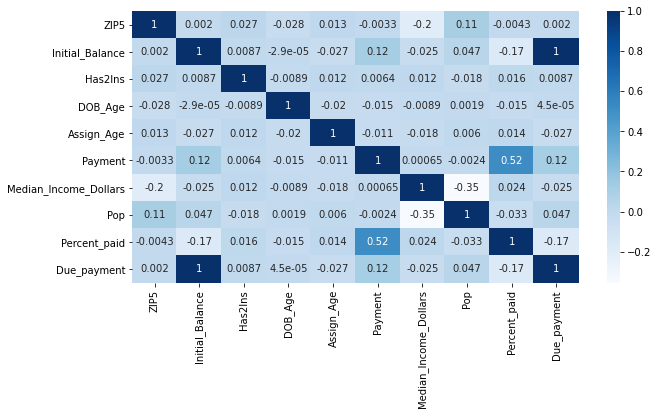

In [48]:
df = rand_df.drop(["ID","Home_Phone"],axis=1)
corr = df.corr()
plt.figure(figsize = (10, 5))
sns.heatmap(corr, cmap="Blues", annot=True)

##From the above correlation we can say there is positive corelation between payment,initial balance,Percent Paid and Due Payment

In [49]:
##Removing the variable Homephone and ID from random variable
randm_df = rand_df.drop(["ID","Home_Phone","DOB_Age"],axis=1)

In [50]:
randm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Facility_Name          4782 non-null   object  
 1   ZIP5                   4782 non-null   int64   
 2   Initial_Balance        4782 non-null   int64   
 3   Has2Ins                4782 non-null   int64   
 4   Financial_Class        4782 non-null   object  
 5   Assign_Age             4782 non-null   int64   
 6   Employed               4782 non-null   object  
 7   Payment                4782 non-null   float64 
 8   Median_Income_Dollars  4782 non-null   float64 
 9   Pop                    4782 non-null   float64 
 10  Percent_paid           4782 non-null   float64 
 11  Due_payment            4782 non-null   float64 
 12  AgeGroup               4782 non-null   category
dtypes: category(1), float64(5), int64(4), object(3)
memory usage: 453.2+ KB


In [51]:
# encode categorical variables
cat_cols = ['Facility_Name',"Financial_Class","Employed","AgeGroup"]
from sklearn.preprocessing import LabelEncoder
# Create an object of the label encoder class
labelencoder = LabelEncoder()
randm_df[cat_cols] = randm_df[cat_cols].apply(labelencoder.fit_transform)

In [52]:
num_cols = ['Initial_Balance','Initial_Balance','Payment','Due_payment',"Percent_paid","Median_Income_Dollars","Pop"]
randm_df[num_cols] = randm_df[num_cols].fillna(0).astype(int)

In [53]:
randm_df

,Facility_Name,ZIP5,Initial_Balance,Has2Ins,Financial_Class,Assign_Age,Employed,Payment,Median_Income_Dollars,Pop,Percent_paid,Due_payment,AgeGroup
0,4,91006,36122,0,0,329,14,0,94085,31715,0,36122,1
1,3,91001,560,0,0,389,14,344,83859,36126,61,216,0
2,1,90815,51,1,1,381,15,0,71281,34554,0,51,2
3,0,90814,3682,0,0,222,15,500,64440,19131,13,3182,0
4,2,90813,128,1,1,182,10,2,28806,56379,1,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,3,90502,964,0,1,393,14,0,65676,18010,0,964,0
4778,3,90501,45,0,0,336,8,0,60024,43180,0,45,1
4779,3,90405,774,0,0,432,2,0,74562,27186,0,774,0
4780,3,90404,365,0,0,185,14,0,56318,21360,0,365,1


In [54]:
### Divide to X and Y datasets
x = randm_df.drop('Payment',axis=1)
##Target Variable
y = randm_df['Payment']

In [55]:
# We specify this so that the train and test data set always have the same rows, respectively
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

### Building our Linear Regression model
We will be using the LinearRegression function from SciKit Learn for its compatibility 

Linear Regression is a machine learning algorithm which performs regression to compute the regression coefficients.
Linear regression looks for optimizing the intersept and coefficients such that it minimizes the error (difference between the predicted value and the observed value) for every instance.

In [56]:
#Fitting the Multiple Linear Regression model
mlr = LinearRegression()  
mlr.fit(x_train, y_train)

LinearRegression()

In [57]:
#Intercept and Coefficient
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(x, mlr.coef_))

Intercept:  0.36767652269164586
Coefficients:


[('Facility_Name', 0.003642060788524931),
 ('ZIP5', -4.397185643630828e-06),
 ('Initial_Balance', 1.000415125782894),
 ('Has2Ins', -0.00043701442725697166),
 ('Financial_Class', -0.00440113033496683),
 ('Assign_Age', 2.987506500872845e-05),
 ('Employed', -0.001187660551482843),
 ('Median_Income_Dollars', 1.0231241325229931e-07),
 ('Pop', 4.733835676436307e-08),
 ('Percent_paid', -0.005212470917113112),
 ('Due_payment', -1.0004154334190998),
 ('AgeGroup', -0.0019295935506438008)]

### Linear Regression Model Evaluation 

In [58]:
#Prediction of test set
y_pred_mlr= mlr.predict(x_test)
#Predicted values
print("Prediction for test set: {}".format(y_pred_mlr))

Prediction for test set: [-2.44540995e-02 -2.22328724e-02  1.14858386e+02 -3.80365106e-02
 -7.76080619e-03 -3.30078449e-02 -2.64662848e-02 -1.36071743e-02
 -2.96638982e-02 -3.41721926e-02  3.95814265e+00 -2.50432238e-02
 -4.09599893e-02 -3.45202732e-02 -1.58169955e-02  6.88344880e+01
  2.18872187e+02 -1.61645825e-02 -3.05572394e-02 -1.01790039e-02
 -2.45025451e-02 -1.70813711e-02 -4.08271304e-02  3.60127203e+02
 -2.91309889e-02  6.79945486e+01 -2.50967135e-02 -3.02107509e-02
  2.10709471e+02 -1.40840829e-02  3.96710133e+00  3.16093593e+02
 -1.69883114e-02  3.52938026e+02 -2.60736199e-02 -2.91472419e-02
 -1.23169117e-02 -1.75505236e-02 -2.49872216e-02 -2.36671657e-02
 -3.23640207e-02 -2.54662890e-02 -2.09791648e-02 -1.33864789e-02
 -2.10341117e-02  3.41104868e+02  4.01695845e+02 -2.67740845e-02
 -2.07337038e-02  1.56000731e+02 -2.65400612e-02 -3.46816089e-02
 -3.22399112e-02 -8.82410253e-03  7.99340580e+01 -2.45670815e-02
 -1.57609820e-02 -2.81613150e-02  2.43929779e+02 -2.32536917e-02


In [59]:
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()

,Actual value,Predicted value
3717,0,-0.024454
128,0,-0.022233
591,115,114.858386
1243,0,-0.038037
1294,0,-0.007761


# Regression metrics for model performance

In [60]:
mse = mean_squared_error(y_test, y_pred_mlr)
print("Mean Square Error(MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Square Error(RMSE):", rmse)

r2 = r2_score(y_test, y_pred_mlr)
print("R squared(R2):", r2)

Mean Square Error(MSE): 0.030309250841934435
Root Mean Square Error(RMSE): 0.17409552217657534
R squared(R2): 0.9999972765773895


In [61]:
##Accuary of the Model
score = mlr.score(x_test, y_test) 


In [62]:
score

0.9999972765773895

##Linear Regression is predicting good with an accuracy of greater than 99% and the model performance metrics like MSE and RMSE are ver low which indicates model performing good.

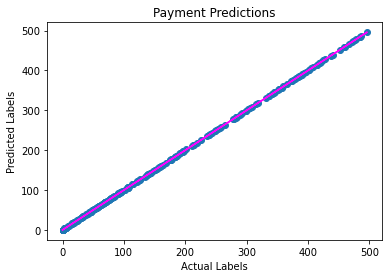

In [63]:
##Straight line for actual and Predicted labels
plt.scatter(y_test, y_pred_mlr)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Payment Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred_mlr, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Mean of Residuals

Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero.

In [64]:
y_train_pred = mlr.predict(x_train)


Text(0.5, 0, 'Errors')

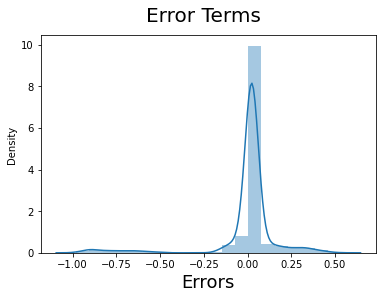

In [65]:
# Validating the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                   
plt.xlabel('Errors', fontsize=18)

Error terms are normally distributed with a mean value ~ 0.

### Ridge Regression Model

Ridge Regression:
In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.
Ridge regression puts constraint on the coefficients (w). It shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity. When  λ
  → 0 , the cost function becomes similar to the linear regression cost function.

Ridge regression can be used when the number of predictor variables exceeds the number of observations, or when a data set has multicollinearity (correlations between predictor variables).

In [66]:
Ridge_model = Ridge().fit(x_train,y_train)

In [67]:
Ridge_model.intercept_

0.3677266693881265

In [68]:
Ridge_model.coef_

array([ 3.64097749e-03, -4.39772934e-06,  1.00041506e+00, -4.37458392e-04,
       -4.39800556e-03,  2.98737136e-05, -1.18762378e-03,  1.02310057e-07,
        4.73434688e-08, -5.21228264e-03, -1.00041537e+00, -1.92866285e-03])

In [69]:
###Model Evaluation and model Performance Metrics

In [70]:
y_pred = Ridge_model.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

0.17409552046674798

In [71]:
r2_score(y_test, y_pred)

0.999997276577443

##Ridge Regression is predicting good with an accuracy of greater than 99% same as linear regression model and the model performance metrics like MSE and RMSE are ver low which indicates model performing good.

In [72]:
x_test.tail(40)


,Facility_Name,ZIP5,Initial_Balance,Has2Ins,Financial_Class,Assign_Age,Employed,Median_Income_Dollars,Pop,Percent_paid,Due_payment,AgeGroup
2543,1,90210,103,0,0,196,15,143667,21741,0,103,1
2803,0,90813,2950,0,0,427,14,28806,56379,0,2950,0
1637,1,90240,186,0,0,265,10,73110,25876,75,46,0
959,4,90401,17329,0,0,298,14,45854,6722,1,17093,0
2182,3,90731,518,0,0,438,6,49006,59662,0,518,0
1616,3,90280,426,0,0,268,10,44481,94396,0,426,1
2298,1,90504,4,0,0,433,10,70185,32102,75,1,0
1271,3,90270,298,0,0,229,15,39857,27372,0,298,0
818,2,90740,136,0,0,413,14,76379,23729,0,136,0
1466,3,90701,774,0,0,421,14,57404,16591,7,714,1


#### Predicting New Data points fron Linear regression Model

In [74]:
###Predicting new data point
new_X = [[4,90740,373,0,0,207,14,76379,23729,0,36122,1]]
print(mlr.predict(new_X))

[-35763.8716348]


In [75]:
new_X = [[1,90240,186,0,0,265,10,73110,25876,75,46,0]]
print(mlr.predict(new_X))

[139.64642997]


### Save the Model

In [76]:
### Save the model with Pickle
linear_model = pickle.dump(mlr, open('model.pkl', 'wb'))

In [77]:
!pip install -U notebook-as-pdf
!pyppeteer-install

  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.18.0
    Uninstalling tqdm-4.18.0:
      Successfully uninstalled tqdm-4.18.0


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

conda 4.10.1 requires ruamel_yaml_conda>=0.11.14, which is not installed.
csvmatch 1.20 requires tqdm==4.18.0, but you'll have tqdm 4.65.0 which is incompatible.
[INFO] Starting Chromium download.

  0%|          | 0.00/137M [00:00<?, ?b/s]
  0%|          | 399k/137M [00:00<00:34, 3.98Mb/s]
  1%|1         | 1.52M/137M [00:00<00:18, 7.51Mb/s]
  3%|2         | 3.98M/137M [00:00<00:08, 15.0Mb/s]
  4%|4         | 6.13M/137M [00:00<00:07, 16.8Mb/s]
  6%|5         | 7.82M/137M [00:00<00:07, 16.5Mb/s]
  7%|7         | 9.67M/137M [00:00<00:07, 17.1Mb/s]
  9%|8         | 11.8M/137M [00:00<00:06, 18.4Mb/s]
 10%|9         | 13.6M/137M [00:00<00:06, 18.3Mb/s]
 12%|#1        | 16.1M/137M [00:00<00:06, 19.2Mb/